In [ ]:
###   Rede Neural Multi-Modal Perception   ###

In [ ]:
###   Importa os arquivos a serem utilizados nesta implementação   ###

#from google.colab import files
#files.upload()

In [ ]:
###   Instala a biblioteca tensorflow_docs   ###

# pip install git+https://github.com/tensorflow/docs

In [1]:
pip install git+https://github.com/tensorflow/docs


  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-nibjfnyp
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-nibjfnyp
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0cc14a8a40d1bddf8f3b04c908c94d69e9d8addce_-cp36-none-any.whl size=114000 sha256=0167cb4a3ce6255c9df7e90fa979a12a35192b32314968989baa45febee67f94
  Stored in directory: /tmp/pip-ephem-wheel-cache-m_ep5fj2/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [2]:
###   Importação de bibliotecas   ###

import tensorflow as tf
import supercon_dados as tsd
import supercon_funcoes_apoio_ML as tsf
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn import preprocessing
from sklearn.cluster import KMeans
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import matplotlib.pyplot as plt


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
###   Verifica se há acesso à GPU   ###


device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
#versão do tensorflow
print(tf.__version__)

2.2.0


In [ ]:
###   Divisão dos dados que serão usados em um processão de validação cruzada para obtenção de melhores parâmetros    ###

X_treino, X_teste, Y_treino, Y_teste = tsf.divisao_dados_treinamento(0.2,tsd.X_modelagem,tsd.Y_modelagem)

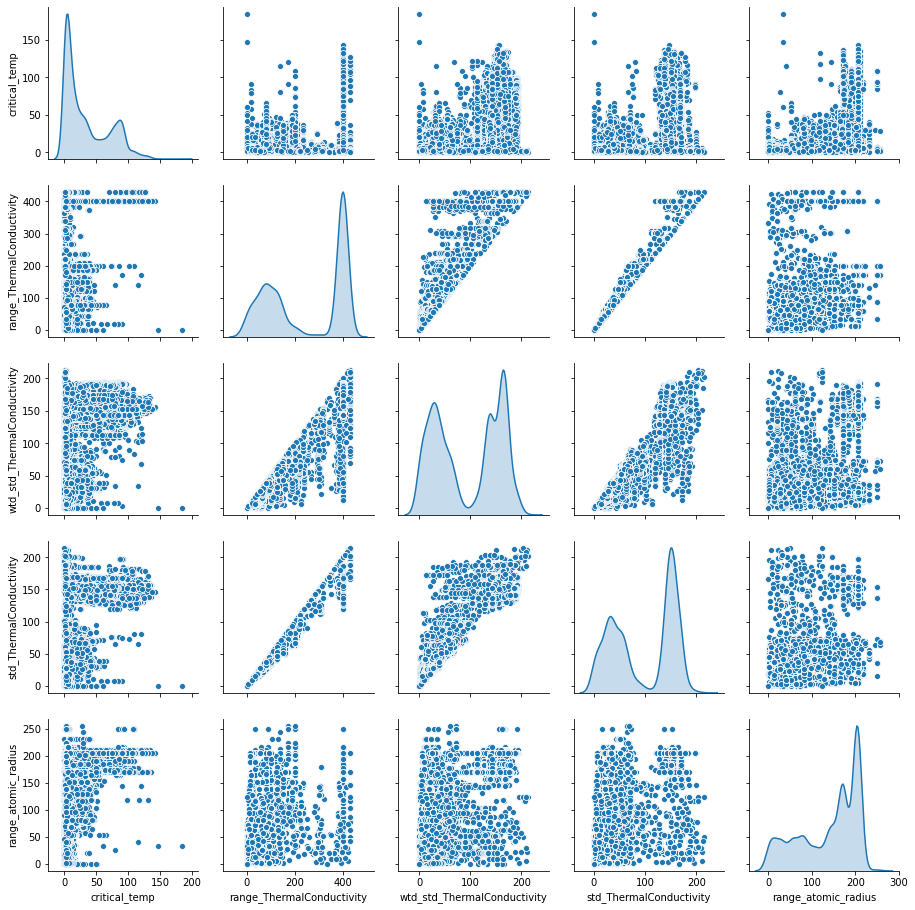

In [5]:
###   Visualização de alguns parâmetros relevantes e as temperaturas críticas  ###

sns.pairplot(tsd.base_geral[['critical_temp','range_ThermalConductivity', 'wtd_std_ThermalConductivity',
       'std_ThermalConductivity', 'range_atomic_radius']], diag_kind="kde")

In [6]:
###   Normalização dos dados de treino   ###

scaler = preprocessing.StandardScaler()
scaler.fit(X_treino)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [7]:
#ver as dimensões do Frame X_treino
X_treino.shape

(17231, 81)

In [ ]:
#Conjunto de treino normalizado
X_treino_N = pd.DataFrame(data = scaler.transform(X_treino),columns = X_treino.columns, index = X_treino.index)

In [ ]:
#Conjunto de teste normalizado
X_teste_N = pd.DataFrame(data = scaler.transform(X_teste),columns = X_teste.columns, index = X_teste.index)

In [ ]:
###   Explorações de cenários para determinação dos melhores hiperparâmetros do modelo   ###  

In [ ]:
#Situação 1

# Arquitetura da rede neural usando Keras (número de camadas e números de neurônios)

def build_model1():

  model1 = keras.Sequential([
    layers.Dense(41, activation='relu', input_shape=[len(X_treino_N.columns)]),
    layers.Dense(21, activation='relu'),
    layers.Dense(1)
  ])

  # Otimizados da função Loss (redução do MSE)

  optimizer = tf.keras.optimizers.Adam(0.001)

  model1.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model1


# Instanciando o modelo
model1 = build_model1()
# Visualização da arquitetura do modelo
model1.summary()

# Armazenamento de dados sobre os hiperparâmetros
gravacao1_t1 =[]
gravacao1_erro =[]
gravacao1_r2 = []

teste1 = [32,64,128]

for t1 in teste1:

  gravacao1_t1.append(t1)

  # Uso da GPU

  with tf.device('/device:GPU:0'):


    # Instanciando o modelo

    model1 = build_model1()

    # Número máximo de etapas (cada etapa corresponde a passagem de todos os dados na rede neural)
    EPOCHS=1000

    # Incorpora a parada antecipado no treinamento do modelo, representa o ponto onde o modelo para de reduzir o rms e auumenta a chance de overfitting
    early_stop1 = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

    # Treina o modelo
    early_history1 = model1.fit(X_treino_N, Y_treino,batch_size=t1,
                        epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                        callbacks=[early_stop1, tfdocs.modeling.EpochDots()])
    
    # Usa o modelo treinado para prediçao 
    lista_predicao1 = model1.predict(X_teste_N).flatten()

    gravacao1_erro.append(np.sqrt(mean_squared_error(lista_predicao1, Y_teste)))   

    gravacao1_r2.append(r2_score(lista_predicao1, Y_teste))       



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 41)                3362      
_________________________________________________________________
dense_1 (Dense)              (None, 21)                882       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 22        
Total params: 4,266
Trainable params: 4,266
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:666.1340,  mae:16.8545,  mse:666.1340,  val_loss:331.8178,  val_mae:13.0630,  val_mse:331.8178,  
....................................................................................................
Epoch: 100, loss:136.6354,  mae:7.5937,  mse:136.6354,  val_loss:166.7901,  val_mae:8.7833,  val_mse:166.7901,  
........................................................

In [ ]:
np.array([gravacao1_t1,gravacao1_erro,gravacao1_r2])

array([[ 32.        ,  64.        , 128.        ],
       [ 11.3084362 ,  11.21102721,  11.634958  ],
       [  0.8836047 ,   0.88032415,   0.86724277]])

In [ ]:
#Situação 2

def build_model2():

  model2 = keras.Sequential([
    layers.Dense(61, activation='relu', input_shape=[len(X_treino_N.columns)]),
    layers.Dense(41, activation='relu'),
    layers.Dense(21, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.Adam(0.001)

  model2.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model2



model2 = build_model2()
model2.summary()

gravacao2_t2 =[]
gravacao2_erro =[]
gravacao2_r2 = []

teste2 = [32,64,128]

for t2 in teste2:

  gravacao2_t2.append(t2)

  with tf.device('/device:GPU:0'):

    model2 = build_model2()

    EPOCHS=1000

    
    early_stop2 = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

    early_history2 = model2.fit(X_treino_N, Y_treino,batch_size=t2,
                        epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                        callbacks=[early_stop2, tfdocs.modeling.EpochDots()])
    
    # model2.evaluate(X_teste_N, Y_teste, verbose=2)

    lista_predicao2 = model2.predict(X_teste_N).flatten()

    gravacao2_erro.append(np.sqrt(mean_squared_error(lista_predicao2, Y_teste)))   

    gravacao2_r2.append(r2_score(lista_predicao2, Y_teste))     

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 61)                5002      
_________________________________________________________________
dense_13 (Dense)             (None, 41)                2542      
_________________________________________________________________
dense_14 (Dense)             (None, 21)                882       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 22        
Total params: 8,448
Trainable params: 8,448
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:480.6615,  mae:14.4825,  mse:480.6615,  val_loss:282.1783,  val_mae:11.4602,  val_mse:282.1783,  
....................................................................................................
Epoch: 100, loss:103.5014,  mae:6.3

In [ ]:
np.array([gravacao2_t2,gravacao2_erro,gravacao2_r2])

array([[ 32.        ,  64.        , 128.        ],
       [ 10.73233048,  10.74557582,  10.98475143],
       [  0.88714254,   0.8918174 ,   0.89051775]])

In [ ]:
#Situação 3

gravacao3_t3 =[]
gravacao3_erro =[]
gravacao3_r2 = []
gravacao3_neuronio = []

neuronio_camada = [162,81,41]

for neuronio in neuronio_camada:

  def build_model3():
    
    model3 = keras.Sequential([
    layers.Dense(neuronio, activation='relu', input_shape=[len(X_treino_N.columns)]),
    layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(0.001)

    model3.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  
    return model3



  model3 = build_model3()
  model3.summary()




  teste3 = [32,64,128]

  for t3 in teste3:

    gravacao3_neuronio.append(neuronio)

    gravacao3_t3.append(t3)

    with tf.device('/device:GPU:0'):

      model3 = build_model3()

      EPOCHS=1000

      # The patience parameter is the amount of epochs to check for improvement
      early_stop3 = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

      early_history3 = model3.fit(X_treino_N, Y_treino,batch_size=t3,
                          epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                          callbacks=[early_stop3, tfdocs.modeling.EpochDots()])
      
      # model3.evaluate(X_teste_N, Y_teste, verbose=2)

      lista_predicao3 = model3.predict(X_teste_N).flatten()

      gravacao3_erro.append(np.sqrt(mean_squared_error(lista_predicao3, Y_teste)))   

      gravacao3_r2.append(r2_score(lista_predicao3, Y_teste))  


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 162)               13284     
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 163       
Total params: 13,447
Trainable params: 13,447
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:588.7293,  mae:16.1726,  mse:588.7293,  val_loss:321.5981,  val_mae:12.6935,  val_mse:321.5981,  
....................................................................................................
Epoch: 100, loss:151.6365,  mae:8.1967,  mse:151.6365,  val_loss:170.2650,  val_mae:8.7828,  val_mse:170.2650,  
...................................................................................................
Epoch: 0, loss:795.7919,  mae:18.7666,  mse:795.7919,  val_loss:358.3284,  val_mae:1

In [ ]:
np.array([gravacao3_neuronio,gravacao3_t3,gravacao3_erro,gravacao3_r2])

array([[162.        , 162.        , 162.        ,  81.        ,
         81.        ,  81.        ,  41.        ,  41.        ,
         41.        ],
       [ 32.        ,  64.        , 128.        ,  32.        ,
         64.        , 128.        ,  32.        ,  64.        ,
        128.        ],
       [ 12.21868112,  11.89983689,  12.23636778,  12.7278799 ,
         12.37235355,  12.7263956 ,  12.75830274,  12.73432407,
         13.20717866],
       [  0.85211474,   0.87315334,   0.85255823,   0.84683473,
          0.85234424,   0.84574338,   0.84016247,   0.84354207,
          0.84009374]])

In [ ]:
### Treinamento do modelo com a melhor arquitetura e hiperparâmetro ###

In [ ]:
def build_model():

  model = keras.Sequential([
    layers.Dense(61, activation='relu', input_shape=[len(X_treino_N.columns)]),
    layers.Dense(41, activation='relu'),
    layers.Dense(21, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.Adam(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [11]:
with tf.device('/device:GPU:0'):

      model = build_model()

      EPOCHS=1000
      
      early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

      early_history = model.fit(X_treino_N, Y_treino,batch_size=32,
                          epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                          callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:537.1315,  mae:15.3150,  mse:537.1315,  val_loss:294.9820,  val_mae:12.0085,  val_mse:294.9820,  
....................................................................................................
Epoch: 100, loss:104.8982,  mae:6.4236,  mse:104.8982,  val_loss:124.4799,  val_mae:7.0438,  val_mse:124.4799,  
....................................................................................................
Epoch: 200, loss:84.2501,  mae:5.6899,  mse:84.2501,  val_loss:119.4393,  val_mae:6.7259,  val_mse:119.4393,  
........................

In [ ]:
plotagem_epoch = pd.DataFrame(early_history.history)

In [ ]:
plotagem_epoch['passos']=early_history.epoch

In [14]:
plotagem_epoch

,loss,mae,mse,val_loss,val_mae,val_mse,passos
0,537.131470,15.314964,537.131470,294.981995,12.008497,294.981995,0
1,265.755249,11.075395,265.755249,256.125427,10.650789,256.125427,1
2,241.698303,10.422097,241.698303,241.076050,10.675570,241.076050,2
3,227.580368,10.076098,227.580368,233.083328,10.505762,233.083328,3
4,215.625092,9.769981,215.625092,216.762894,9.878531,216.762894,4
...,...,...,...,...,...,...,...
219,81.806351,5.613436,81.806351,117.923790,6.788229,117.923790,219
220,81.809990,5.573549,81.809990,117.302292,6.956988,117.302292,220
221,79.870789,5.529781,79.870789,116.966148,6.641884,116.966148,221
222,82.162933,5.629095,82.162933,115.469124,6.650045,115.469124,222


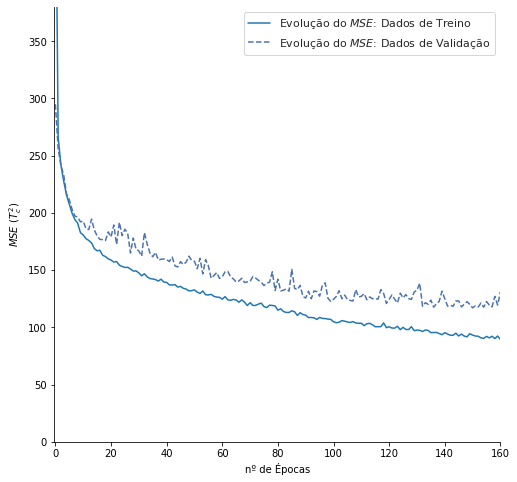

In [15]:
###  Plota a otimização que o otimizador faz sobre o RMS perante a evolução do número de etapas   ###
fig, ax = plt.subplots(figsize=(8, 8))
sns.set(style="ticks")
sns.despine()
plt.plot(plotagem_epoch['passos'],plotagem_epoch['mse'], label = 'Evolução do $MSE$: Dados de Treino')
plt.plot(plotagem_epoch['passos'],plotagem_epoch['val_mse'],"b--",label = 'Evolução do $MSE$: Dados de Validação')
plt.ylim([0, 380])
plt.xlim([-0.5, 160])
plt.ylabel('$MSE$ ($T_{c}^{2}$)')
plt.xlabel('nº de Épocas')
plt.legend()
plt.savefig('dnn_epoca.png', format='png')

In [ ]:
#example_batch = X_treino_N[:10]
#example_result = model.predict(example_batch)
#example_result

In [ ]:
#hist = pd.DataFrame(history.history)
#hist['epoch'] = history.epoch
#hist.tail()

In [ ]:
#plotter.plot({'Basic': history}, metric = "mse")
#plt.ylim([0, 300])
#plt.ylabel('MSE [Tc (K)]')

In [ ]:
### Avalia do modelo treinado ###

model.evaluate(X_teste_N, Y_teste, verbose=2)

135/135 - 0s - loss: 125.2961 - mae: 6.7429 - mse: 125.2961


[125.29608917236328, 6.742924690246582, 125.29608917236328]

In [ ]:
###   Imprime o resultado dos dados treinados   ###

print('\n R^2: \n', r2_score(model.predict(X_treino_N).flatten(), Y_treino) , '\n RMSE : \n',np.sqrt(mean_squared_error(model.predict(X_treino_N).flatten(), Y_treino))) 


 R^2: 
 0.9181478183089908 
 RMSE : 
 9.829159508039643


In [ ]:
###   Imprime o resultado dos dados nunca treinados   ###

print('\n R^2: \n', r2_score(model.predict(X_teste_N).flatten(), Y_teste) , '\n RMSE : \n',np.sqrt(mean_squared_error(model.predict(X_teste_N).flatten(), Y_teste))) 


 R^2: 
 0.8952411384057267 
 RMSE : 
 11.193573095366219


In [ ]:
# mínimo de predição para os dados de treino

min(model.predict(X_treino_N).flatten())

-5.765386

In [ ]:
# mínimo de predição para os dados de teste

min(model.predict(X_teste_N).flatten())

-8.0799

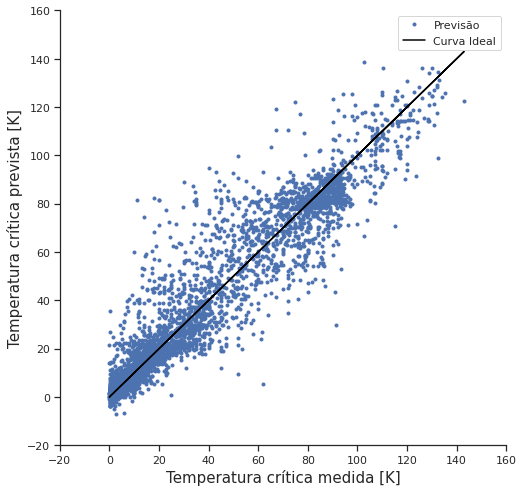

<Figure size 432x288 with 0 Axes>

In [ ]:
###   Visualização dos resultados de treinamento sobre dados nunca treinados pelo modelo   ###


print_x = Y_teste
print_y = model.predict(X_teste_N).flatten()

f, ax = plt.subplots(figsize=(8, 8))

sns.set(style="ticks")
sns.despine()

plt.plot(print_x,print_y, 'b.',label = 'Previsão')
plt.plot(print_x,print_x, '-', label = 'Curva Ideal', color = 'black')
plt.xlabel('Temperatura crítica medida [K]',fontsize = 15)
plt.ylabel('Temperatura crítica prevista [K]',fontsize = 15)
plt.legend()
plt.xticks(np.linspace(-20, 160, 10, endpoint=True))
plt.yticks(np.linspace(-20, 160, 10, endpoint=True))
plt.axis([-20,160,-20,160])

plt.show()
plt.savefig('dnn_Tp_Tc.png', format='png')

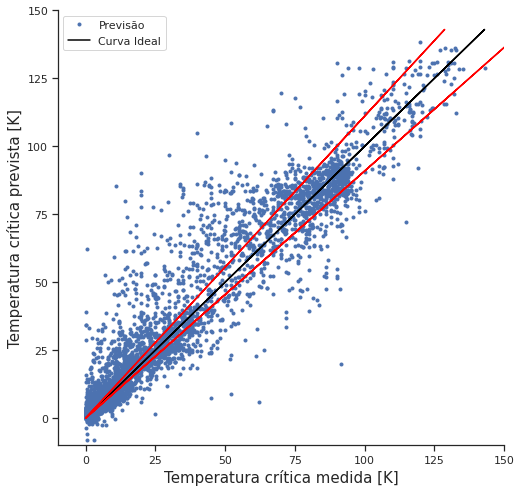

In [ ]:
###   Gráfico que mostra sa previsões sobre o conjunto de teste   ###


print_x = Y_teste
print_y = model.predict(X_teste_N).flatten()

fig, ax = plt.subplots(figsize=(8, 8))
# plt.title('Tc prevista pelo modelo vs. Tc medida em laboratório')
sns.set(style="ticks")
sns.despine()

plt.plot(print_x,print_y, 'b.',label = 'Previsão')
plt.plot(print_x,print_x, '-', label = 'Curva Ideal', color = 'black')
plt.plot(print_x*0.9,print_x, '-', color = 'red')
plt.plot(print_x*1.1,print_x, '-', color = 'red')

plt.xlabel('Temperatura crítica medida [K]',fontsize = 15)
plt.ylabel('Temperatura crítica prevista [K]',fontsize = 15)
plt.legend('Previsão')
plt.legend()
plt.xticks(np.linspace(0, 150, 7, endpoint=True))
plt.yticks(np.linspace(0, 150, 7, endpoint=True))
plt.axis([-10,150,-10,150])

plt.show()

In [ ]:
#Dados das previsões e do banco de dados NIMS

dados_agrupamento=pd.DataFrame({'Y_teste':Y_teste ,'Y_previsto':model.predict(X_teste_N).flatten()})

In [ ]:
dados_agrupamento['Desvio'] = abs((dados_agrupamento['Y_previsto']-dados_agrupamento['Y_teste']))/dados_agrupamento['Y_teste']

In [ ]:
# condições para avaliar as faixas de temperatura

def agrupar(x):
    
    lista = np.linspace(0, 150,16)
    
    for i in range(len(lista)):
        
        if x['Y_teste']<lista[i+1] and x['Y_teste']>=lista[i]:
            
            return i 
        
dados_agrupamento['grupo'] = dados_agrupamento.apply(agrupar, axis=1)

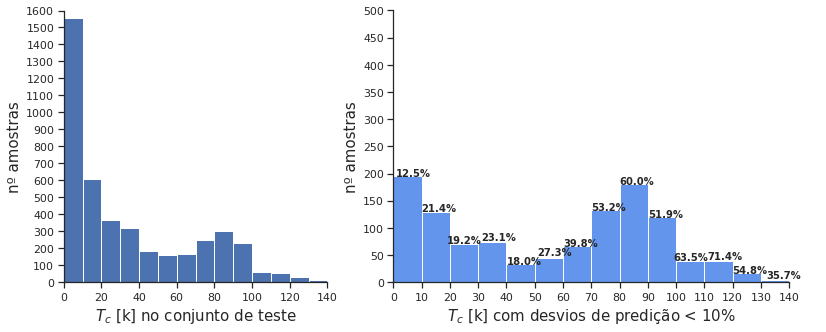

In [33]:
f, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 6]},figsize=(13, 5) )

sns.set(style="ticks")
sns.despine()

y = []

for c in range(max(dados_agrupamento['grupo'])+1):
    
    y.append(len(dados_agrupamento.loc[dados_agrupamento['grupo']==c]))

ax[0].bar(np.linspace(0, 140,15,endpoint=True)+5,np.array(y),width=10)


y2 = []

for c in range(max(dados_agrupamento['grupo'])+1):


    y2.append(len(dados_agrupamento.loc[(dados_agrupamento['grupo']==c)&(dados_agrupamento['Desvio']<=0.1)]))
    
ax[1].bar(np.linspace(0, 140,15,endpoint=True)+5,np.array(y2),color='cornflowerblue',width=10)   



for c in range(max(dados_agrupamento['grupo'])+1):
    
    if c==0 or c==14:
        
        a = len(dados_agrupamento.loc[(dados_agrupamento['grupo']==c)&(dados_agrupamento['Desvio']<=0.1)])
        b = len(dados_agrupamento.loc[(dados_agrupamento['grupo']==c)])
        p = round((a/b)*100, 1)

        cx = c*10

        ax[1].annotate(str(p)+'%', xy = (cx+1,a),fontsize = 10,fontweight='bold')

    elif c==13:
        
        a = len(dados_agrupamento.loc[(dados_agrupamento['grupo']==c)&(dados_agrupamento['Desvio']<=0.1)])
        b = len(dados_agrupamento.loc[(dados_agrupamento['grupo']==c)])
        p = round((a/b)*100, 1)

        cx = c*10

        ax[1].annotate(str(p)+'%', xy = (cx+2,a+3),fontsize = 10,fontweight='bold')

    elif c==3:
        
        a = len(dados_agrupamento.loc[(dados_agrupamento['grupo']==c)&(dados_agrupamento['Desvio']<=0.1)])
        b = len(dados_agrupamento.loc[(dados_agrupamento['grupo']==c)])
        p = round((a/b)*100, 1)

        cx = c*10

        ax[1].annotate(str(p)+'%', xy = (cx+1,a+3),fontsize = 10,fontweight='bold')

    elif c==2:
        
        a = len(dados_agrupamento.loc[(dados_agrupamento['grupo']==c)&(dados_agrupamento['Desvio']<=0.1)])
        b = len(dados_agrupamento.loc[(dados_agrupamento['grupo']==c)])
        p = round((a/b)*100, 1)

        cx = c*10

        ax[1].annotate(str(p)+'%', xy = (cx-1,a),fontsize = 10,fontweight='bold')

    elif c==5:
        
        a = len(dados_agrupamento.loc[(dados_agrupamento['grupo']==c)&(dados_agrupamento['Desvio']<=0.1)])
        b = len(dados_agrupamento.loc[(dados_agrupamento['grupo']==c)])
        p = round((a/b)*100, 1)

        cx = c*10

        ax[1].annotate(str(p)+'%', xy = (cx+1,a+5),fontsize = 10,fontweight='bold')

    elif c==10:
        
        a = len(dados_agrupamento.loc[(dados_agrupamento['grupo']==c)&(dados_agrupamento['Desvio']<=0.1)])
        b = len(dados_agrupamento.loc[(dados_agrupamento['grupo']==c)])
        p = round((a/b)*100, 1)

        cx = c*10

        ax[1].annotate(str(p)+'%', xy = (cx-1,a),fontsize = 10,fontweight='bold')

    elif c==11:
        
        a = len(dados_agrupamento.loc[(dados_agrupamento['grupo']==c)&(dados_agrupamento['Desvio']<=0.1)])
        b = len(dados_agrupamento.loc[(dados_agrupamento['grupo']==c)])
        p = round((a/b)*100, 1)

        cx = c*10

        ax[1].annotate(str(p)+'%', xy = (cx+1,a+3),fontsize = 10,fontweight='bold')
    
    else:
        
        a = len(dados_agrupamento.loc[(dados_agrupamento['grupo']==c)&(dados_agrupamento['Desvio']<=0.1)])
        b = len(dados_agrupamento.loc[(dados_agrupamento['grupo']==c)])
        p = round((a/b)*100, 1)

        cx = c*10

        ax[1].annotate(str(p)+'%', xy = (cx,a),fontsize = 10,fontweight='bold')


ax[0].set_ylabel('nº amostras',fontsize = 15)
ax[0].set_xlabel('$T_c$ [k] no conjunto de teste',fontsize = 15)
ax[1].set_ylabel('nº amostras',fontsize = 15)
ax[1].set_xlabel('$T_c$ [k] com desvios de predição < 10%',fontsize = 15)

ax[0].axis([0,140,0,1600])
ax[1].axis([0,140,0,500])

ax[0].set_yticks(np.linspace(0, 1600, 17, endpoint=True))
ax[0].set_xticks(np.linspace(0, 140, 8, endpoint=True))

ax[1].set_yticks(np.linspace(0, 500, 11, endpoint=True))
ax[1].set_xticks(np.linspace(0, 140, 15, endpoint=True))

plt.savefig('dnn_erros.png', format='png')

In [ ]:
### Testes com supercondutores do DEMAR EEL USP ###

In [ ]:
# 9.5 K no Ti2GeC
# 4.1 K no HfV2Ga4
# 4.0 K no NiTe2
# 3.1 K no Ti2InC
# 7.8 K no Nb2SnC
# 8.7 K no Zr0.96V0.04B2
# 15.3 K no Nb5Ge3
# 7 K no Zr5Pt3C0.3

In [ ]:
# 9.5 K no Ti2GeC

model.predict(scaler.transform(tsd.calcular(tsd.fatiar('Ti2GeC'))))

Material:  Ti2Ge1C1


array([[15.221796]], dtype=float32)

In [ ]:
# 4.1 K no HfV2Ga4

model.predict(scaler.transform(tsd.calcular(tsd.fatiar('HfV2Ga4'))))

Material:  Hf1V2Ga4


array([[9.304821]], dtype=float32)

In [ ]:
# 4.0 K no NiTe2

model.predict(scaler.transform(tsd.calcular(tsd.fatiar('NiTe2'))))

Material:  Ni1Te2


array([[3.880466]], dtype=float32)

In [ ]:
# 3.1 K no Ti2InC

model.predict(scaler.transform(tsd.calcular(tsd.fatiar('Ti2InC'))))

Material:  Ti2In1C1


array([[2.278258]], dtype=float32)

In [ ]:
# 7.8 K no Nb2SnC

model.predict(scaler.transform(tsd.calcular(tsd.fatiar('Nb2SnC'))))

Material:  Nb2Sn1C1


array([[4.9790497]], dtype=float32)

In [ ]:
# 8.7 K no Zr0.96V0.04B2

model.predict(scaler.transform(tsd.calcular(tsd.fatiar('Zr0.96V0.04B2'))))

Material:  Zr0.96V0.04B2


array([[8.754316]], dtype=float32)

In [ ]:
# 15.3 K no Nb5Ge3

model.predict(scaler.transform(tsd.calcular(tsd.fatiar('Nb5Ge3'))))

Material:  Nb5Ge3


array([[7.241033]], dtype=float32)

In [ ]:
# 7 K no Zr5Pt3C0.3

model.predict(scaler.transform(tsd.calcular(tsd.fatiar('Zr5Pt3C0.3'))))

Material:  Zr5Pt3C0.3


array([[4.769256]], dtype=float32)